In [1]:
# data_collection.py
import pandas as pd
from faker import Faker
import random
from datetime import datetime, timedelta

fake = Faker()
data = []

threat_types = ["Malware", "Phishing", "DDoS", "Ransomware", "SQL Injection", "Zero-Day"]
severity_levels = ["Low", "Medium", "High", "Critical"]
sources = ["Firewall", "IDS", "SIEM", "Endpoint", "Threat Feed"]
actions_taken = ["Blocked", "Quarantined", "Escalated", "Ignored"]

for _ in range(200000):
    record = {
        "threat_id": fake.uuid4(),
        "timestamp": fake.date_time_between(start_date='-6M', end_date='now'),
        "source": random.choice(sources),
        "threat_type": random.choice(threat_types),
        "severity": random.choice(severity_levels),
        "ip_address": fake.ipv4(),
        "location": fake.country(),
        "action_taken": random.choice(actions_taken),
        "response_time_sec": random.randint(1, 600)
    }
    data.append(record)

df = pd.DataFrame(data)
df.to_csv("threat_data.csv", index=False)


In [6]:
# data_cleaning.py
import pandas as pd

df = pd.read_csv("threat_data.csv")

df.head()


,threat_id,timestamp,source,threat_type,severity,ip_address,location,action_taken,response_time_sec
0,d6dc4c80-646c-4b99-84da-668a6890cfce,2025-03-22 09:30:48,Threat Feed,SQL Injection,Critical,69.61.28.162,Togo,Blocked,299
1,b2251411-042e-496a-8bd6-171946ee2085,2025-07-23 11:43:24,IDS,Zero-Day,Low,141.171.66.240,Malta,Ignored,149
2,171b2497-8dca-428b-8d92-0c804eb3bccf,2025-02-16 21:53:33,Endpoint,Zero-Day,High,217.161.234.17,Uzbekistan,Quarantined,266
3,c1263fe6-6db2-4aa3-9141-73476212c7a2,2025-03-04 21:18:39,IDS,Phishing,Low,126.38.90.145,Vanuatu,Escalated,515
4,32dbf506-d21f-44f8-b36c-3822388315dd,2025-03-10 02:40:20,Endpoint,Zero-Day,Low,98.151.93.82,France,Blocked,169


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   threat_id          200000 non-null  object
 1   timestamp          200000 non-null  object
 2   source             200000 non-null  object
 3   threat_type        200000 non-null  object
 4   severity           200000 non-null  object
 5   ip_address         200000 non-null  object
 6   location           200000 non-null  object
 7   action_taken       200000 non-null  object
 8   response_time_sec  200000 non-null  int64 
dtypes: int64(1), object(8)
memory usage: 13.7+ MB


In [4]:
df["threat_id"] = pd.factorize(df["threat_id"])[0].astype("int64")

print(df["threat_id"].dtype) 
print(df["threat_id"].head())

int64
0    0
1    1
2    2
3    3
4    4
Name: threat_id, dtype: int64


In [5]:
df.describe()

,threat_id,response_time_sec
count,200000.000000,200000.000000
mean,99999.500000,301.047445
std,57735.171256,173.306152
min,0.000000,1.000000
25%,49999.750000,151.000000
50%,99999.500000,301.000000
75%,149999.250000,452.000000
max,199999.000000,600.000000


In [6]:
df.isnull().sum()

threat_id            0
timestamp            0
source               0
threat_type          0
severity             0
ip_address           0
location             0
action_taken         0
response_time_sec    0
dtype: int64

In [8]:
df.duplicated().sum()


np.int64(0)

In [8]:
# Severity distribution
print("Severity levels:\n", df["severity"].value_counts())

# Response time stats
print("Response time (sec):\n", df["response_time_sec"].describe())

Severity levels:
 severity
Low         50170
Medium      50085
Critical    49950
High        49795
Name: count, dtype: int64
Response time (sec):
 count    200000.000000
mean        301.047445
std         173.306152
min           1.000000
25%         151.000000
50%         301.000000
75%         452.000000
max         600.000000
Name: response_time_sec, dtype: float64


In [9]:
df.to_csv("cleaned_threat_data.csv", index=False)

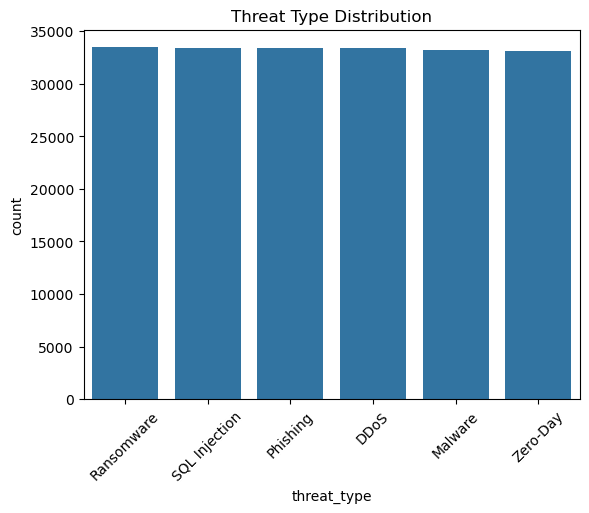

In [9]:
# data_exploration.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("cleaned_threat_data.csv")

# Threat type distribution
sns.countplot(data=df, x="threat_type", order=df["threat_type"].value_counts().index)
plt.title("Threat Type Distribution")
plt.xticks(rotation=45)
plt.show()

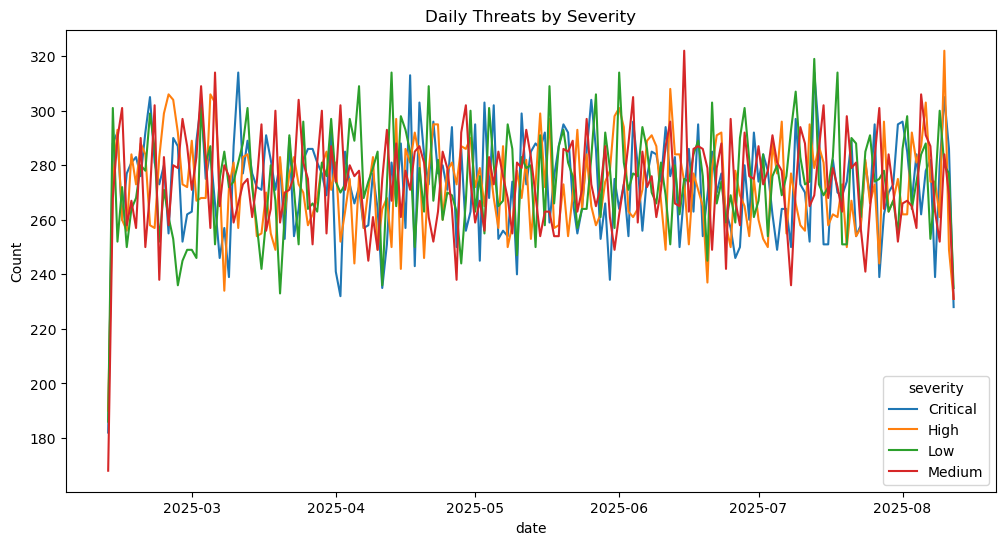

In [11]:
# Severity over time
df["date"] = pd.to_datetime(df["timestamp"]).dt.date
severity_daily = df.groupby(["date", "severity"]).size().unstack().fillna(0)
severity_daily.plot(figsize=(12,6))
plt.title("Daily Threats by Severity")
plt.ylabel("Count")
plt.show()

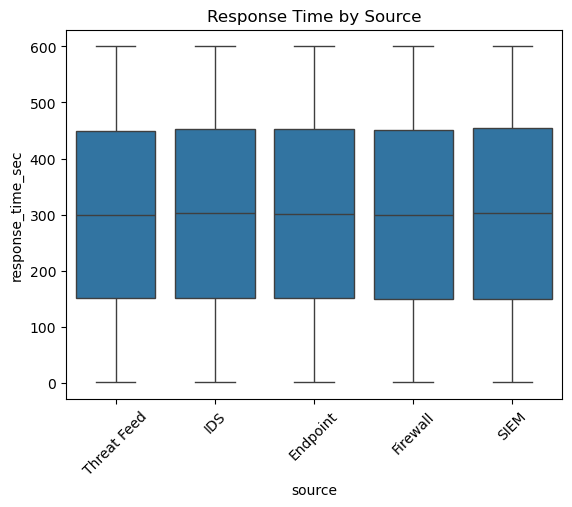

In [12]:
# Response time by source
sns.boxplot(data=df, x="source", y="response_time_sec")
plt.title("Response Time by Source")
plt.xticks(rotation=45)
plt.show()

In [13]:
# data_modeling.py
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib

df = pd.read_csv("cleaned_threat_data.csv")

# Binary target
df["is_critical"] = df["severity"].apply(lambda x: 1 if x == "Critical" else 0)

# Encode categorical features
df_encoded = pd.get_dummies(df[["source", "threat_type", "action_taken"]], drop_first=True)

X = pd.concat([df[["response_time_sec"]], df_encoded], axis=1)
y = df["is_critical"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save model
joblib.dump(model, "threat_severity_model.pkl")


['threat_severity_model.pkl']

In [14]:
# model_evaluation.py
from sklearn.metrics import classification_report
import joblib

model = joblib.load("threat_severity_model.pkl")
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.75      0.83      0.79     30010
           1       0.26      0.18      0.21      9990

    accuracy                           0.67     40000
   macro avg       0.50      0.50      0.50     40000
weighted avg       0.63      0.67      0.64     40000



In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   threat_id          200000 non-null  int64 
 1   timestamp          200000 non-null  object
 2   source             200000 non-null  object
 3   threat_type        200000 non-null  object
 4   severity           200000 non-null  object
 5   ip_address         200000 non-null  object
 6   location           200000 non-null  object
 7   action_taken       200000 non-null  object
 8   response_time_sec  200000 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 13.7+ MB
